# PS 4

## Ex 2.1

In [99]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as optimizer
import scipy.linalg as la


#### Set Parameters

In [100]:
A = 1 # productivity 
alpha = 0.35 # capital / income 
beta = 0.96 ** 20 #20-year discount rate
delta = 1 - (1 - 0.05) ** 20 #20-year depreciation rate
sigma = 3 #risk aversion coefficient
lb = np.array([1, 1, 0.2]) #labor supplies
SS_tol = 1e-09 #error tolerance
f_params = (lb, A, alpha, delta) 

#### Define functions

In [101]:
get_r = lambda alpha, A, L, K, delta: alpha * A * ((L / K) ** (1 - alpha)) - delta
get_w = lambda alpha, A, L, K: (1 - alpha) * A * ((K / L) ** alpha)
get_K = lambda b2, b3: b2+b3
get_cons = lambda b_s, b_s_1, n_s, r, w: w * n_s + (1 + r) * b_s - b_s_1
get_util = lambda c, sigma=3: (c ** (1 - sigma))/(1 - sigma)
get_MU = lambda c, sigma=3: c ** (-sigma)
get_Y = lambda alpha, A, L, K,: A * (K ** alpha) * (L ** (1-alpha))

In [102]:
def feasible(f_params, bvec_guess):
    lb, A, alpha, delta = f_params
    b2, b3 = bvec_guess
    K = get_K(b2, b3)
    L = np.sum(lb)
    r = get_r(alpha, A, L, K, delta)
    w = get_w(alpha, A, L, K)
    
    c1 = get_cons(0, b2, lb[0], r, w)
    c2 = get_cons(b2, b3, lb[1], r, w)
    c3 = get_cons(b3, 0, lb[2], r, w)
    
    b_cnstr = np.zeros(2, dtype="bool")
    
    c_cnstr = np.zeros(3, dtype="bool")
    c_cnstr[0], c_cnstr[1], c_cnstr[2] = (c1 <= 0), (c2 <= 0), (c3 <= 0)
    
    K_cnstr = np.zeros(1, dtype="bool")
    K_cnstr[0] = K <= 0
    
    
    if c_cnstr[0]:
        b_cnstr[0] = True
    if c_cnstr[1]:
        b_cnstr[0],b_cnstr[1] = True, True
    if c_cnstr[1]:
        b_cnstr[1] = True
    
    return b_cnstr, c_cnstr, K_cnstr

### Ex 2.1(a)

In [103]:
res = feasible(f_params, np.array([1.0, 1.2]))
print("b_cnstr: {} , c_cnstr: {} , K_cnstr:{} ".format(res[0],res[1],res[2]))
print("Constraints violated.")

b_cnstr: [ True False] , c_cnstr: [ True False False] , K_cnstr:[False] 
Constraints violated.


### Ex 2.1(b)

In [104]:
res = feasible(f_params, np.array([0.06, -0.001]))
print("b_cnstr: {} , c_cnstr: {} , K_cnstr:{} ".format(res[0],res[1],res[2]))
print("No Constraints violated.")

b_cnstr: [False False] , c_cnstr: [False False False] , K_cnstr:[False] 
No Constraints violated.


### Ex 2.1(c)

In [105]:
res = feasible(f_params, np.array([0.1, 0.1]))
print("b_cnstr: {} , c_cnstr: {} , K_cnstr:{} ".format(res[0],res[1],res[2]))
print("No Constraints violated.")

b_cnstr: [False False] , c_cnstr: [False False False] , K_cnstr:[False] 
No Constraints violated.


## Ex 2.2

In [106]:
# For Euler Errors
def EulEqs(bvec, f_params):
    lb, A, alpha, delta, beta = f_params
    b2, b3 = bvec
    
    K = get_K(b2, b3)
    L = lb.sum()
    r = get_r(alpha, A, L, K, delta)
    w = get_w(alpha, A, L, K)
    
    c1 = get_cons(0, b2, lb[0], r, w)
    c2 = get_cons(b2, b3, lb[1], r, w)
    c3 = get_cons(b3, 0, lb[2], r, w)
    
    MU1,MU2,MU3 = get_MU(c1),get_MU(c2),get_MU(c3)
    
    Eul1 = beta * (1 + r) * MU2 - MU1
    Eul2 = beta * (1 + r) * MU3 - MU2
    
    return np.array([Eul1, Eul2])

In [107]:
# Define the `get_SS` function
def get_SS(params, bvec_guess, SS_graphs=False):
    start_time = time.perf_counter()
    beta, sigma, lb, L, A, alpha, delta, SS_tol = params
    f_params = np.array([lb, A, alpha, delta, beta])
    b_ss = optimizer.root(EulEqs, bvec_guess, tol=SS_tol, args=(f_params)).x
    
    b2, b3 = b_ss
    K_ss = get_K(b2, b3)
    r_ss = get_r(alpha, A, L, K_ss, delta)
    w_ss = get_w(alpha, A, L, K_ss)
    Y_ss = get_Y(alpha, A, L, K_ss)
    
    c1 = get_cons(0, b2, lb[0], r_ss, w_ss)
    c2 = get_cons(b2, b3, lb[1], r_ss, w_ss)
    c3 = get_cons(b3, 0, lb[2], r_ss, w_ss)
    c_ss = np.array([c1, c2, c3])
    C_ss = c_ss.sum()
    EulErr_ss = EulEqs(b_ss, f_params)
    RCerr_ss = Y_ss - C_ss - delta * K_ss
    
    ss_time = time.perf_counter() - start_time
    ss_output = {
        "b_ss": b_ss, "c_ss": c_ss, "w_ss": w_ss, "r_ss": r_ss, 
        "K_ss": K_ss, "Y_ss": Y_ss, "C_ss": C_ss,
        "EulErr_ss": EulErr_ss, "RCerr_ss": RCerr_ss,
        "ss_time": ss_time
        
    }
    
    if SS_graphs:
        fig, ax = plt.subplots()
        ax.plot(np.arange(1, 4), c_ss, marker="o", label="consumption")
        ax.plot(np.arange(2, 4), b_ss, marker="o", label="savings")
        ax.legend()
        ax.set_title("Steady-state Distribution of Consumption and Savings in Equilibrium by ages")
        plt.show();
        
    return ss_output

### Ex 2.2(a),(b)

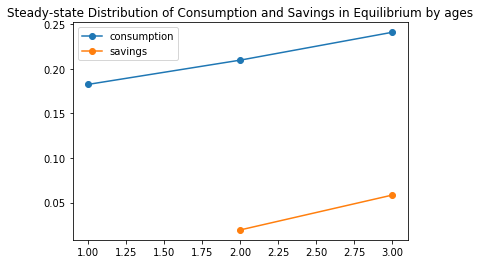

{'b_ss': array([0.01931274, 0.05841159]), 'c_ss': array([0.18241256, 0.20961491, 0.24087382]), 'w_ss': 0.2017252935955733, 'r_ss': 2.4330302535646116, 'K_ss': 0.07772432611811347, 'Y_ss': 0.6827625321696328, 'C_ss': 0.6329012827935535, 'EulErr_ss': array([ 1.33582034e-12, -2.67164069e-12]), 'RCerr_ss': 3.469446951953614e-17, 'ss_time': 0.0005025489999752608}


In [108]:
params = (beta, sigma, lb, lb.sum(), A, alpha, delta, SS_tol)
bvec_guess = np.array([0.1, 0.1])
ss_output = get_SS(params, bvec_guess,True)
print(ss_output)

### Ex 2.2(c)

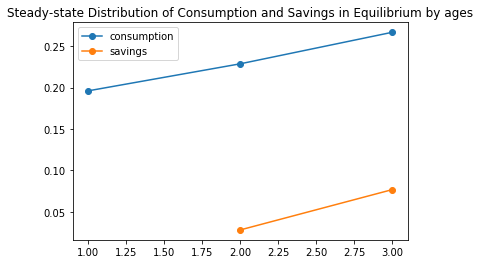

{'b_ss': array([0.02817696, 0.07686557]), 'c_ss': array([0.19597535, 0.22861559, 0.26669216]), 'w_ss': 0.22415231191003315, 'r_ss': 1.8863599991452351, 'K_ss': 0.10504252550764615, 'Y_ss': 0.7586693633878046, 'C_ss': 0.6912831045288896, 'EulErr_ss': array([2.84217094e-14, 2.84217094e-14]), 'RCerr_ss': 9.71445146547012e-17, 'ss_time': 0.0003131040002699592}


In [109]:
params = (0.55, sigma, lb, lb.sum(), A, alpha, delta, SS_tol)
bvec_guess = np.array([0.1, 0.1])
ss_output = get_SS(params, bvec_guess,True)
print(ss_output)

If househols become more patient, the consumption and saving over the period and $\bar{w}$ increases while $\bar{r}$ decreases. 
The reason may be that households tend to postpone their consumtions and save more at present. And the resulted higher demand and lower interest rate from more capital savings brings increase in wages.


## Ex 2.3

In [111]:
def get_b3(b1, b2, r_path, w_path, params, bvec_guess):
    b3_params = [b1, b2, r_path, w_path, params]
    result = optimizer.root(EulEqs_1, bvec_guess[0], args=b3_params, tol=params[7])
    b3 = result.x
    b3_EulErrs = result.fun
    
    return np.array([b3, b3_EulErrs])

In [112]:
def get_path(T, K_path, K_bar, params):
    beta, sigma, lb, L, A, alpha, delta, eul_tol = params
    r_path = np.zeros(T)
    w_path = np.zeros(T)
    for t in range(T):
        r_path[t] = get_r(alpha, A, L, K_path[t], delta)
        w_path[t] = get_w(alpha, A, L, K_path[t])
    
    r_bar = get_r(alpha, A, L, K_bar, delta)
    w_bar = get_w(alpha, A, L, K_bar)
    r_path = np.append(r_path, r_bar)
    w_path = np.append(w_path, w_bar)
    
    return np.array([r_path, w_path])

In [113]:
def get_b_EulErr(b, b_params):
    t, r_path, w_path, params = b_params
    b1, b2 = b[0], b[1]
    lb0, lb1,lb2 = params[2][0], params[2][1],params[2][2]
    r_t_1,r_t_2 = r_path[t + 1],r_path[t + 2]
    w_t, w_t_1, w_t_2  = w_path[t],w_path[t + 1],w_path[t+2]
    
    c21 = get_cons(0, b1, lb0, 0, w_t)
    c22 = get_cons(b1, b2, lb1, r_t_1,w_t_1)
    MU21 = get_MU(c21)
    MU22 = get_MU(c22)
    Eul2 = params[0] * (1 + r_path[t + 1]) * MU22 - MU21
    
    c31 = get_cons(b1, b2, lb1, r_t_1, w_t_1)
    c32 = get_cons(b2, 0, lb2, r_t_2, w_t_2)
    MU31 = get_MU(c31)
    MU32 = get_MU(c32)
    Eul3 = params[0] * (1 + r_path[t + 2]) * MU32 - MU31
    
    return np.array([Eul2, Eul3])

def get_b(t, r_path, w_path, params, bvec_guess):
    b_params = [t, r_path, w_path, params]
    result = optimizer.root(get_b_EulErr, bvec_guess, args=b_params, tol=params[7])
    b = result.x
    b_EulErrs = result.fun
    
    return np.array([b, b_EulErrs])

In [114]:
def get_errors(K_path, r_path, w_path, bmat, params):
    L = params[2].sum()
    C = L * w_path[:-1] + (1 + r_path[:-1]) * bmat[:-1, 0] - bmat[1:, 0] + (1 + r_path[:-1]) * bmat[:-1, 1] - bmat[1:, 1]
    Y = params[4] * (K_path[:-1] ** params[5]) * (L ** (1 - params[5]))
    agg_err = Y - C - K_path[1:] + (1 - params[6]) * K_path[:-1]

In [115]:
def get_result(T, r_path, w_path, K_path, bvec_guess, b_ss, params):
    bmat = np.zeros((T + 1, 2))
    bmat[0, :] = bvec_guess
    EulErrs = np.zeros((T + 1, 2))
    cols = [0, 1]
    
    for t in range(T - 1):
        rows = [t + 1, t + 2]
        bmat[rows, cols], EulErrs[rows, cols] = get_b(t, r_path, w_path, params, bvec_guess)
    
    bmat[1, 1], EulErrs[1, 1] = get_b3(bmat[0, 0], bmat[0, 1], r_path, w_path, params, bvec_guess)
    max_EulErrs = np.abs(EulErrs).max(axis=0)
    agg_errs = get_errors(K_path, r_path, w_path, bmat, params)
    
    return bmat, max_EulErrs, agg_errs

In [116]:
def K_prime(bmat, K_bar):
    K_p_path = bmat[:-1, :].sum(axis=1)
    K_p_path = np.append(K_p_path, K_bar)
    
    return K_p_path

In [117]:
def TPI(T, K_path, K_bar, bvec_guess, b_ss, params, tol, max_iter):
    dist = 1e9
    i = 0
    while (dist > tol) & (i < max_iter):
        i += 1
        r_path, w_path = get_path(T, K_path, K_bar, params)
        bmat, max_EulErrs, max_agg_errs = get_result(T, r_path, w_path, K_path, bvec_guess, b_ss, params)
        K_p_path = K_prime(bmat, K_bar)
        dist = la.norm(K_p_path - K_path, 2)
        K_path = xi * K_p_path + (1 - xi) * K_path
        
    print("Max absolute Euler errors are {}.".format((max_EulErrs)))
    print("Max absolute aggregate resources constraint error is {}.".format(max_agg_errs))
    
    return K_path, r_path, w_path

In [118]:
L = lb.sum()
T = 30
tol = 1e-09
xi = 0.2
eul_tol = 1e-06
max_iter = 10000
params = (beta, sigma, lb, L, A, alpha, delta, eul_tol)

In [119]:
b_ss = get_SS(params, bvec_guess)["b_ss"]
b2_bar, b3_bar = b_ss

b21 = 0.8 * b2_bar
b31 = 1.1 * b3_bar
bvec_guess = np.array([b21, b31])

K1 = get_K(b21, b31)
K_bar = get_K(b2_bar, b3_bar)
K_path = np.linspace(K1, K_bar, T)
K_path = np.append(K_path, K_bar)

In [120]:
#(a)
K, r, w = TPI(T, K_path, K_bar, bvec_guess, b_ss, params, tol, max_iter)

Max absolute Euler errors are [1.04482800e-06 2.88958191e-07].
Max absolute aggregate resources constraint error is None.


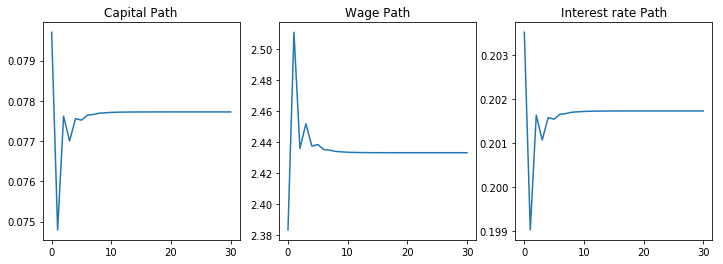

In [126]:
fig, ax = plt.subplots(figsize=(12, 4), ncols=3)
titles = ['Capital', 'Wage', 'Interest rate']
path = [K,r,w]
for i,p in enumerate(path):
    ax[i].plot(p)
    ax[i].set_title("{} Path".format(titles[i]))

### Ex 2.2(c)

In [128]:
K_dist = np.abs(K - K_bar)
err = 1e-05
loc1 = np.where(K_dist < err)[0]
print("States to first time close to aggregate capital of stock capital is {}.".format(loc1.min()))
loc2 = loc1[-len(np.ediff1d(loc1) == 1)]
print("\nStates to finally time coverge on aggregate capital of stock capital is {}.".format(loc2))

States to first time close to aggregate capital of stock capital is 11.

States to finally time coverge on aggregate capital of stock capital is 12.
